In [2159]:
import noise
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import exp
from tqdm import tqdm
import heapq
#help(noise)
#http://libnoise.sourceforge.net/glossary/
def sample2D(a,i,j):
    i,j=np.clip(i,0,a.shape[0]-1),np.clip(j,0,a.shape[1]-1)
    i0,i1,j0,j1=int(np.floor(i)),int(np.ceil(i)),int(np.floor(j)),int(np.ceil(j))
    return a[i0,j0]*(i1-i)*(j1-j)+a[i1,j0]*(i-i0)*(j1-j)+a[i0,j1]*(i1-i)*(j-j0)+a[i1,j1]*(i-i0)*(j-j0)
def clip(value, lower, upper):
    return lower if value < lower else upper if value > upper else value

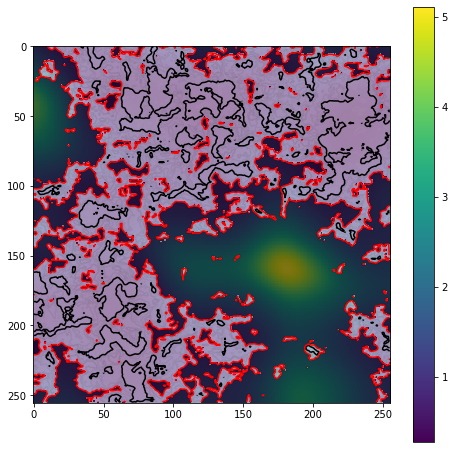

In [2444]:
# get elevation
seed=8476
townseed=3
#seed=128
#seed=325
#seed=236
#seed=127
size=256
zoom=16
zoom2=8
villagedense=25
y0,x0=0,0
distortion=2
elevation = np.zeros((size,size))
gammas = np.zeros((size,size))
xcoord,ycoord=np.mgrid[0:size,0:size]/zoom
random=np.zeros((size,size))
for i in range(size):
    for j in range(size):
        x,y=i/zoom+x0,j/zoom+y0
        dx=distortion*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+15)
        dy=distortion*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+23)
        gamma=noise.pnoise2(x/zoom2,y/zoom2,octaves=2,persistence=0.5,lacunarity=2,base=seed+66)
        gamma=np.exp(3*gamma+0.2)
        value=clip(0.5+noise.pnoise2(x+0.5*dx,y+0.5*dy,octaves=6,persistence=0.5,lacunarity=2.0,base=seed+0),0.01,1)
        value=value**gamma
        gammas[i,j]=gamma
        elevation[i,j] = 2*value-1
        random[i,j]=noise.pnoise2(x*8,y*8,octaves=4,persistence=0.7,lacunarity=2.0,base=seed+54)
#r=np.sqrt((xcoord-2)**2+(ycoord-2)**2)
#elevation=0.5-0.4*((r-0.5)/0.5)**2

plt.figure(figsize=(8,8))
plt.imshow(gammas,cmap='viridis')
plt.colorbar()
plt.imshow(elevation>0,alpha=0.5)
plt.contour(np.clip(elevation,0,1),alpha=0.1)
plt.contour(elevation,[0.5],colors='black')
plt.contour(elevation,[0],colors='red')
plt.show()

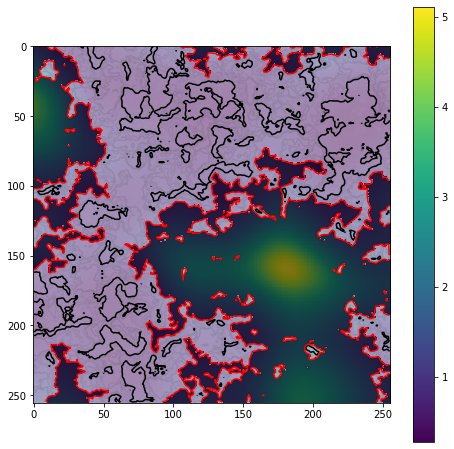

In [2354]:
# fillout small oceans
visited=elevation<-1
dirs=((0,1),(1,0),(0,-1),(-1,0))
for i0 in range(size):
    for j0 in range(size):
        if elevation[i0,j0]<=0 and not visited[i0,j0]:
            opened=[]
            closed=[]
            count=0
            opened.append((i0,j0))
            visited[i0,j0]=True
            count+=1
            while len(opened)>0:
                i,j=opened.pop()
                closed.append((i,j))
                for oo,delta in enumerate(dirs):
                    ii,jj=i+delta[0],j+delta[1]
                    if 0<=ii and ii<size and 0<=jj and jj<size:
                        if not visited[ii,jj] and elevation[ii,jj]<=0:
                            opened.append((ii,jj))
                            visited[ii,jj]=True
                            count+=1
                    else:
                        count+=zoom
            if count<1.2*zoom**2:
                for p in closed:
                    elevation[p[0],p[1]]=0.1
plt.figure(figsize=(8,8))
plt.imshow(gammas,cmap='viridis')
plt.colorbar()
plt.imshow(elevation>0,alpha=0.5)
plt.contour(np.clip(elevation,0,1),alpha=0.1)
plt.contour(elevation,[0.5],colors='black')
plt.contour(elevation,[0],colors='red')
plt.show()

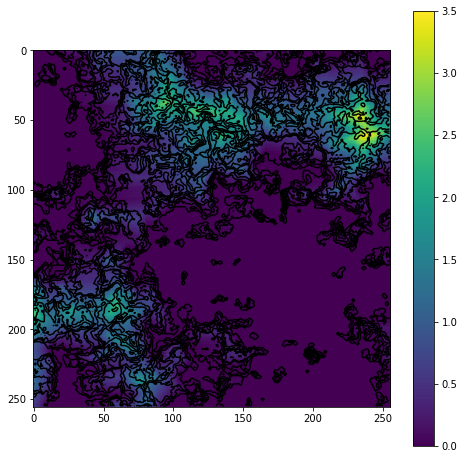

In [2355]:
# get rainshadow
dist=np.zeros((size,size))
dist.fill(float('inf'))
dirs=((0,1),(1,0),(0,-1),(-1,0))
opened=[]
for i in range(size):
    for j in range(size):
        if elevation[i,j]<=0:
            opened.append((0,i,j,0))
heapq.heapify(opened)
while len(opened)>0:
    d,i,j,o=heapq.heappop(opened)
    if dist[i,j]>d:
        dist[i,j]=d
        for oo,delta in enumerate(dirs):
            ii,jj=i+delta[0],j+delta[1]
            if 0<=ii and ii<size and 0<=jj and jj<size:
                if elevation[ii,jj]>0:
                    cost=elevation[ii,jj]+0.5*(1-delta[1])
                    if elevation[ii,jj]>0.5:
                        cost+=1
                    if dist[ii,jj]>d+cost:
                        heapq.heappush(opened,(d+cost,ii,jj,oo))
rainshadow=dist.copy()/zoom
del dist,dirs,opened
plt.figure(figsize=(8,8))
plt.imshow(rainshadow,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black')
plt.show()



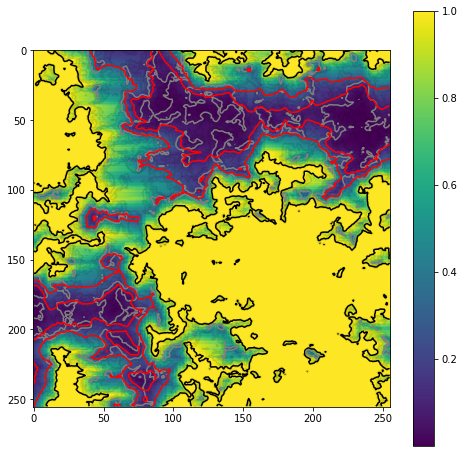

In [2356]:
rain=np.exp(-rainshadow/0.5)
plt.figure(figsize=(8,8))
plt.imshow(rain,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.contour(rain,[0.1],colors='red')
plt.contour(rain,[0.3],colors='red')
plt.show()

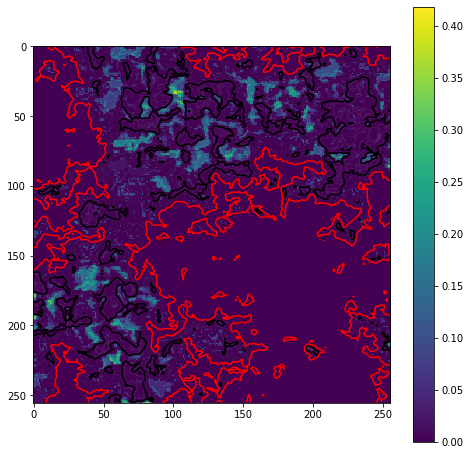

In [2357]:
# get lakes and waterflow
# https://medium.com/universe-factory/how-i-generated-artificial-rivers-on-imaginary-continents-747df12c5d4c

fill=np.clip(elevation,0,1)
orig=np.zeros((size,size),dtype=np.int8)
drained=elevation<-1
dirs=((0,1),(1,0),(0,-1),(-1,0))
opened=[]
for i in range(size):
    for j in range(size):
        if elevation[i,j]<-0.01:
            opened.append((0,i,j,0))
heapq.heapify(opened)
#this bfs runs unexpectionally slow. may debug
np.random.seed(seed+2564)
while len(opened)>0:
    f,i,j,o=heapq.heappop(opened)
    if not drained[i,j]:
        drained[i,j]=True
        fill[i,j]=f
        orig[i,j]=(o+2)%4
        for oo,delta in enumerate(dirs):
            ii,jj=i+delta[0],j+delta[1]
            if 0<=ii and ii<size and 0<=jj and jj<size:
                if not drained[ii,jj]:
                    ff=max(f,clip(elevation[ii,jj],0,1))+np.random.random()*0.001
                    #random breaks priority but not break algorithm, why?
                    #ff=max(f,clip(elevation[ii,jj],0,1))+random[ii,jj]*0.01+random[i,j]*0.005
                    heapq.heappush(opened,(ff,ii,jj,oo))
fill-=np.clip(elevation,0,1)
downstream=orig.copy()

plt.figure(figsize=(8,8))
plt.imshow(elevation>0,alpha=0.5)
plt.imshow(fill,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),alpha=0.1)
plt.contour(elevation,[0.5],colors='black')
plt.contour(elevation,[0],colors='red')
plt.show()


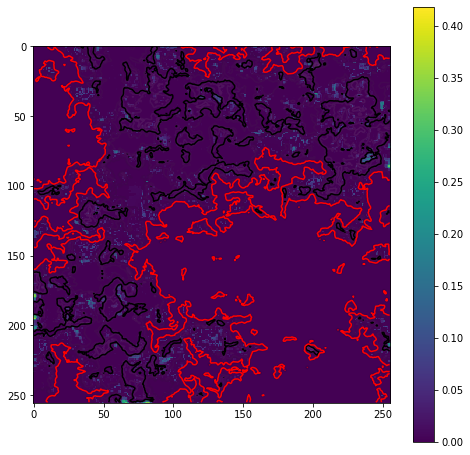

In [2358]:
# fillout big lakes
visited=elevation<-1
dirs=((0,1),(1,0),(0,-1),(-1,0))
for i0 in range(size):
    for j0 in range(size):
        if fill[i0,j0]>0.01 and not visited[i0,j0]:
            opened=[]
            closed=[]
            count=0
            opened.append((i0,j0))
            visited[i0,j0]=True
            count+=1
            while len(opened)>0:
                i,j=opened.pop()
                closed.append((i,j))
                for oo,delta in enumerate(dirs):
                    ii,jj=i+delta[0],j+delta[1]
                    if 0<=ii and ii<size and 0<=jj and jj<size:
                        if not visited[ii,jj] and fill[ii,jj]>0.01:
                            opened.append((ii,jj))
                            visited[ii,jj]=True
                            count+=1
            if count>0.2*zoom**2:
                for p in closed:
                    elevation[p[0],p[1]]+=fill[p[0],p[1]]
                    fill[p[0],p[1]]=0
                    
plt.figure(figsize=(8,8))
plt.imshow(elevation>0,alpha=0.5)
plt.imshow(fill,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),alpha=0.1)
plt.contour(elevation,[0.5],colors='black')
plt.contour(elevation,[0],colors='red')
plt.show()

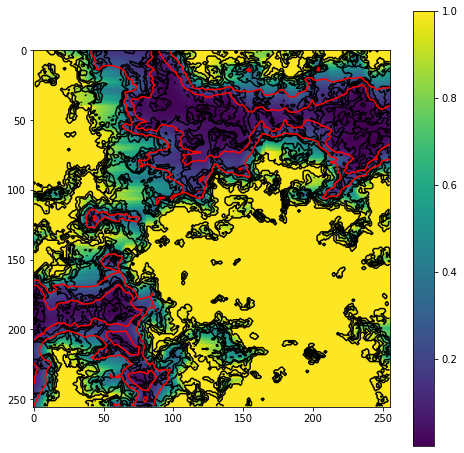

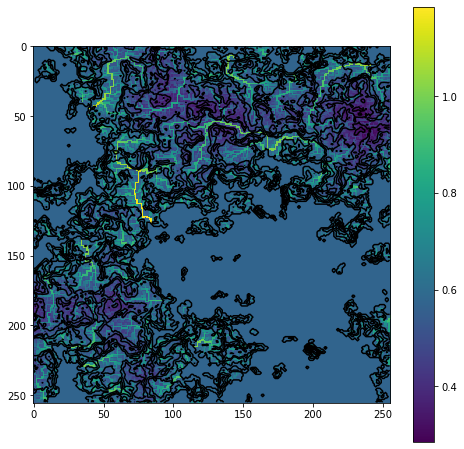

In [2359]:
# generate rivers
flow=rain.copy()
degrees=np.zeros((size,size),dtype=np.int8)
dirs=((0,1),(1,0),(0,-1),(-1,0))
opened=[]
for i in range(size):
    for j in range(size):
        if elevation[i,j]>0:
            found=False
            for oo,delta in enumerate(dirs):
                ii,jj=i+delta[0],j+delta[1]
                if 0<=ii and ii<size and 0<=jj and jj<size:
                    if elevation[ii,jj]>0:
                        if downstream[ii,jj]==(oo+2)%4:
                            found=True
                            degrees[i,j]+=1
            if degrees[i,j]==0:
                degrees[i,j]=1
                opened.append((i,j,0))
while len(opened)>0:
    i,j,f=opened.pop()
    flow[i,j]+=f
    degrees[i,j]-=1
    if degrees[i,j]==0:
        o=downstream[i,j]
        ii,jj=i+dirs[o][0],j+dirs[o][1]
        if elevation[ii,jj]>0:
            opened.append((ii,jj,flow[i,j]))
flow/=zoom**2
    
plt.figure(figsize=(8,8))
plt.imshow(rain,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black')
plt.contour(rain,[0.1],colors='red')
plt.contour(rain,[0.3],colors='red')
plt.show()
plt.figure(figsize=(8,8))
plt.gray()
plt.imshow(flow**0.1,cmap='viridis')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black')
plt.show()

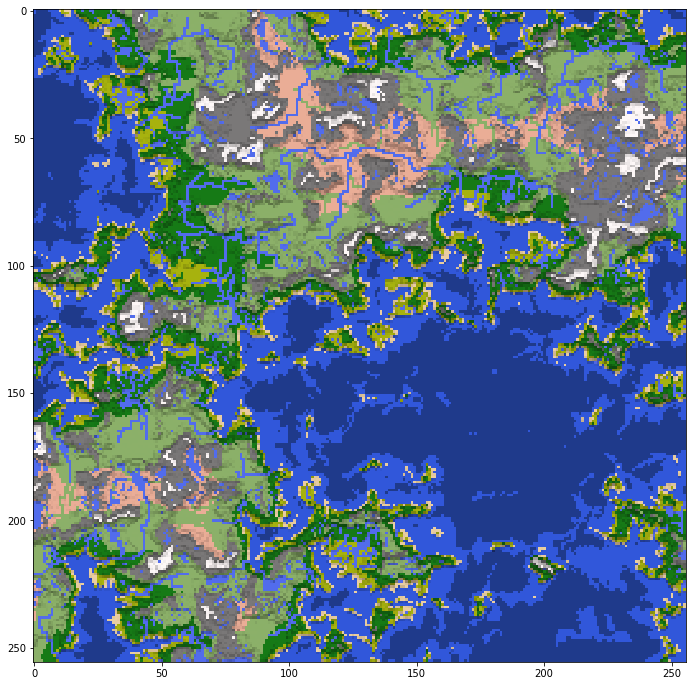

In [2360]:
biome_color=dict()
biome_color['deep ocean']=np.array([45,75,155])
biome_color['ocean']=np.array([65,105,225])
biome_color['lake']=np.array([100,125,240])
biome_color['river']=np.array([100,125,240])
biome_color['grassland']=np.array([155,188,122])
biome_color['forest']=np.array([34,139,34])
biome_color['rainforest']=np.array([180,190,24])
biome_color['beach']=np.array([238, 214, 175])
biome_color['desert']=np.array([238, 185, 165])
biome_color['snow']=np.array([255, 250, 250])
biome_color['mountain']=np.array([139, 137, 137])
biome_color['red']=np.array([255, 12, 13])
biome_color['unknown']=np.array([0, 12, 13])
biomeID={name: id for (id, name) in enumerate(biome_color.keys())}
biomeName={id: name for (id, name) in enumerate(biome_color.keys())}
for k,v in enumerate(biomeID):
    biome_color[k]=biome_color[v]

def getBiome(elevation,fill,rain,flow):
    if elevation < -0.4:
        return 'deep ocean'
    elif elevation < 0:
        return 'ocean'
    else:
        if fill>0.01:
            return 'lake'
        elif flow>1.5/zoom:
            return 'river'
        else:
            if elevation < 0.07:
                return 'beach'
            elif elevation < 0.5:
                if rain>0.8 and elevation<0.2:
                    return 'rainforest'
                elif rain+0.5*flow>0.3+0.9*elevation:
                    return 'forest'
                elif rain>0.1 or flow>0.01:
                    return 'grassland'
                else:
                    return 'desert'
            elif elevation < 0.7:
                return 'mountain'
            else:
                return 'snow'
    return 'unknown'


biomes = np.zeros((size,size),dtype=np.int8)
color_world = np.zeros((size,size,3))
for i in range(elevation.shape[0]):
    for j in range(elevation.shape[1]):
        name=getBiome(elevation[i,j],fill[i,j],rain[i,j],flow[i,j])
        biomes[i,j]=biomeID[name]
        color_world[i,j]=biome_color[name]/255
ef=np.clip(elevation,0,1)+fill
gradX=(ef-np.roll(ef,1,axis=1))*zoom
gradX[:,0]=0
gradY=(ef-np.roll(ef,1,axis=0))*zoom
gradY[0,:]=0
shade=np.cos(np.arctan(gradY)-0.1)*0.4+0.6
color_world=np.einsum('ijk,ij->ijk',color_world,shade)**1.2

plt.figure(figsize=(12,12))
plt.imshow(color_world)
plt.show()


In [2438]:
def pfa(source,cost,banned,cutoff=float('inf')):
    dist=np.zeros((size,size))
    orig=np.zeros((size,size),dtype=np.int8)
    dist.fill(float('inf'))
    orig.fill(-1)
    dirs=((0,1),(1,0),(0,-1),(-1,0))
    opened=[]
    for i in range(size):
        for j in range(size):
            if source[i,j] and not banned[i,j]:
                opened.append((0,i,j,-1))
    heapq.heapify(opened)
    while len(opened)>0:
        d,i,j,o=heapq.heappop(opened)
        if d>cutoff:
            break
        if dist[i,j]>d:
            dist[i,j]=d
            orig[i,j]=(o+2)%4
            for oo,delta in enumerate(dirs):
                ii,jj=i+delta[0],j+delta[1]
                if 0<=ii and ii<size and 0<=jj and jj<size:
                    if not banned[ii,jj]:
                        c=cost[ii,jj,oo]
                        if dist[ii,jj]>d+c:
                            heapq.heappush(opened,(d+c,ii,jj,oo))
    return dist,orig
def sigmoid(x,halfwidth=1):
    return 1/(1+np.exp(-x/(2*halfwidth)))

/home/wenhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


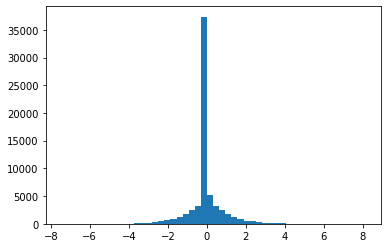

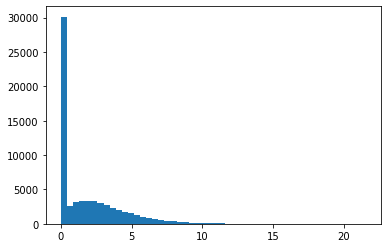

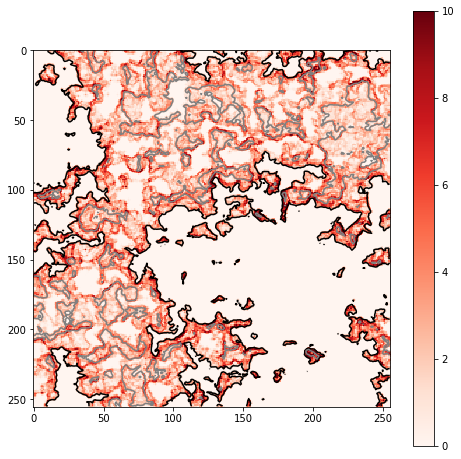

In [2439]:
uneven=np.abs(gradX)+np.abs(gradY)+np.abs(np.roll(gradX,-1,axis=1))+np.abs(np.roll(gradY,-1,axis=0))
plt.hist(gradX.flatten(()),bins=50)
plt.show()
plt.hist(uneven.flatten(),bins=50)
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(np.clip(uneven,0,10),cmap='Reds')
plt.colorbar()
#plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.show()

In [2440]:
travel_cost=np.zeros((size,size,4))
travel_cost[:,:,0]=np.abs(gradX)
travel_cost[:,:,1]=np.abs(gradY)
travel_cost[:,:,2]=np.abs(np.roll(gradX,-1,axis=1))
travel_cost[:,:,3]=np.abs(np.roll(gradY,-1,axis=0))#todo check
travel_cost=(travel_cost*5+1)/zoom
for i in range(size):
    for j in range(size):
        if biomeName[biomes[i,j]] in ['river','lake','ocean']:
            travel_cost[i,j,:]=0.1/zoom

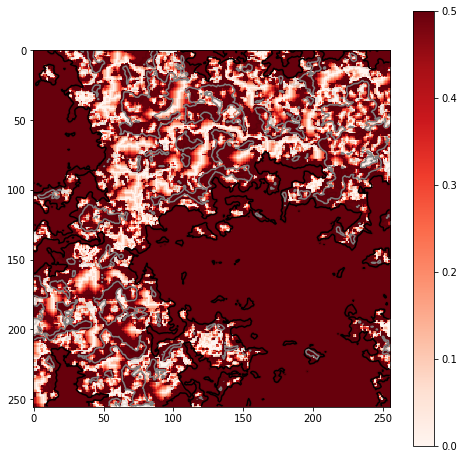

In [2441]:
water_dist,dummy=pfa(source=np.isin(biomes,[biomeID['river'],biomeID['lake']]),
                        #cost=np.ones((size,size,4))/zoom,
                        cost=travel_cost,
                        banned=elevation<=0)
plt.figure(figsize=(8,8))
plt.imshow(np.clip(water_dist,0,0.5),cmap='Reds')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.show()

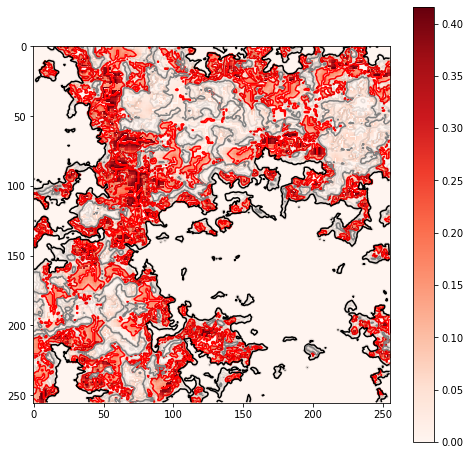

In [2442]:
habitable=sigmoid(0.2-water_dist,0.2)
habitable*=sigmoid(3-uneven,4)
habitable*=\
    +np.where(biomes==biomeID['forest'],1.2,0)\
    +np.where(biomes==biomeID['beach'],0.8,0)\
    +np.where(biomes==biomeID['rainforest'],0.6,0)\
    +np.where(biomes==biomeID['grassland'],0.5,0)\
    +np.where(biomes==biomeID['desert'],0.1,0)\
    +np.where(biomes==biomeID['mountain'],0.2,0)
plt.figure(figsize=(8,8))
plt.imshow(color_world)
plt.imshow(habitable,cmap='Reds',alpha=1)
plt.colorbar()
plt.contour(habitable,[0.1],colors='red')
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.show()

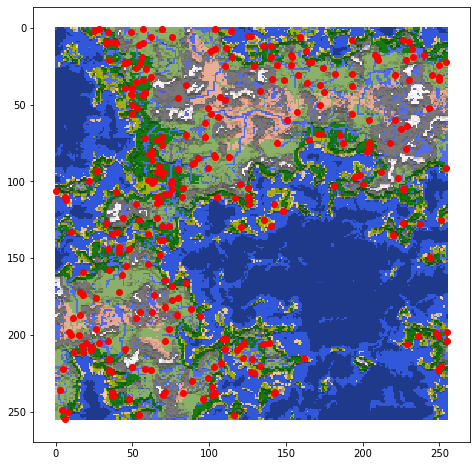

In [2445]:
habitable_p=habitable.flatten()/np.sum(habitable)
villages=[]
def getij(ij):
    return int(ij/size),ij%size
np.random.seed(seed+townseed)
for _i in range(int(villagedense*np.sum(habitable)/zoom**2)):
    i,j=getij(np.random.choice(size*size,p=habitable_p))
    villages.append((i,j))
villages=np.array(villages)
plt.figure(figsize=(8,8))
plt.imshow(color_world)
plt.scatter(villages[:,1],villages[:,0],c='red')
plt.show()

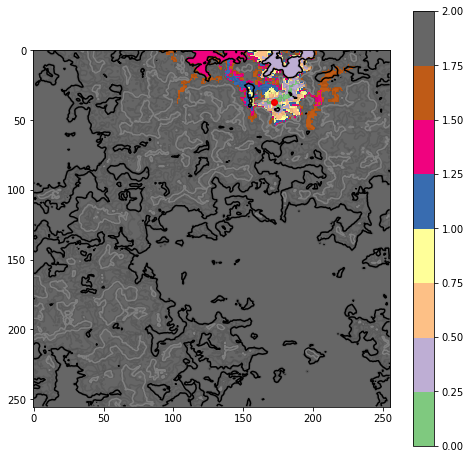

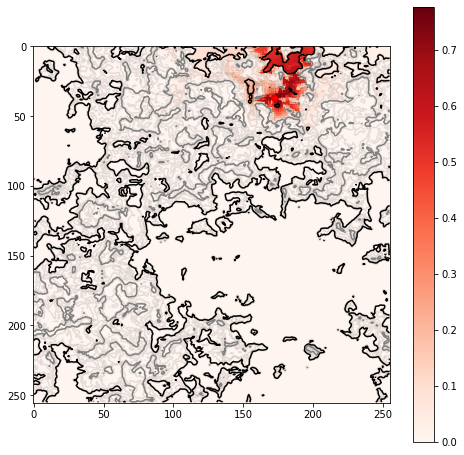

In [2450]:
tid=0
source=elevation<-1
source[villages[tid,0],villages[tid,1]]=True
pop_dist,dummy=pfa(source=source,
                    cost=travel_cost,
                    banned=elevation<-1)
plt.figure(figsize=(8,8))
plt.imshow(np.clip(pop_dist,0,2),cmap='Accent')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.scatter(villages[tid,1],villages[tid,0],color='red')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(sigmoid(0.5-pop_dist,0.2),cmap='Reds')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.scatter(villages[tid,1],villages[tid,0],color='red')
plt.show()


 94%|█████████▍| 278/295 [00:34<00:02,  5.73it/s]


100%|██████████| 295/295 [00:36<00:00,  8.09it/s]


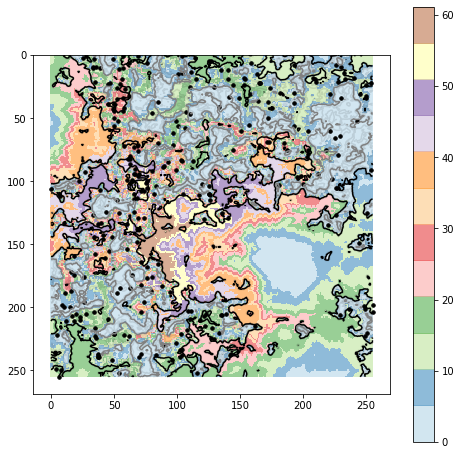

In [2451]:
reach=np.zeros((size,size))
def addReach(i,j):
    source=elevation<-1
    source[i,j]=True
    pop_dist,dummy=pfa(source=source,
                        cost=travel_cost,
                        banned=elevation<-1,
                        cutoff=2)
    np.copyto(reach,reach+sigmoid(1-pop_dist,0.5))
    
for tid in tqdm(range(villages.shape[0])):
    addReach(villages[tid,0],villages[tid,1])
    '''plt.figure(figsize=(3,3))
    plt.imshow(np.clip(pop_dist,0,1),cmap='Accent')
    #plt.colorbar()
    plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
    plt.contour(elevation,[0],colors='black')
    plt.contour(elevation,[0.5],colors='grey')
    plt.scatter(villages[tid,1],villages[tid,0],color='red')
    plt.show()'''
plt.figure(figsize=(8,8))
plt.imshow(reach,cmap='Paired',alpha=0.5)
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.scatter(villages[:,1],villages[:,0],c='black',s=12)
plt.show()


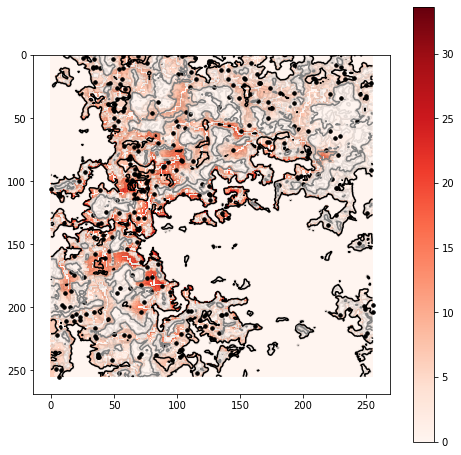

In [2452]:
commercial=reach*sigmoid(0.1-habitable,0.1)
commercial[habitable<=0]=0
plt.figure(figsize=(8,8))
#plt.imshow(biomes==biomeID['river'])
plt.imshow(commercial,cmap='Reds')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.scatter(villages[:,1],villages[:,0],c='black',s=12)
plt.show()


100%|██████████| 98/98 [00:16<00:00,  5.83it/s]


Villages: 295 Towns: 98


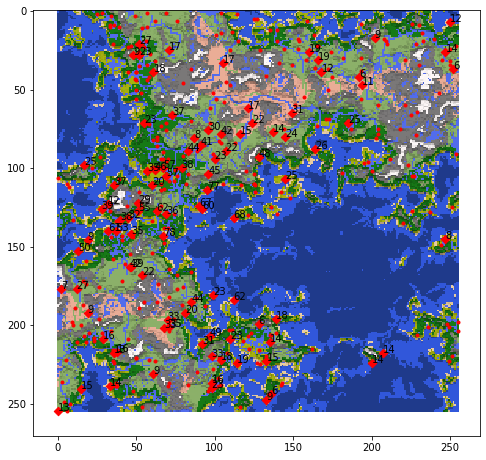

In [2453]:
towns=[]
np.random.seed(seed+townseed+1)
for _i in tqdm(range(int(len(villages)/3))):
    commercial=reach*sigmoid(0.1-habitable,0.1)
    commercial[habitable<=0]=0
    commercial_p=commercial.flatten()/np.sum(commercial)
    i,j=getij(np.random.choice(size*size,p=commercial_p))
    towns.append((i,j,reach[i,j]))
    addReach(i,j)
towns=np.array(towns)
plt.figure(figsize=(8,8))
plt.imshow(color_world)
plt.scatter(villages[:,1],villages[:,0],c='red',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='red',marker='D')
for i in range(len(towns)):
    plt.annotate("{:.0f}".format(towns[i,2]), (towns[i,1], towns[i,0]))
print("Villages:",len(villages), "Towns:",len(towns))
plt.show()


100%|██████████| 98/98 [01:13<00:00,  1.33it/s]


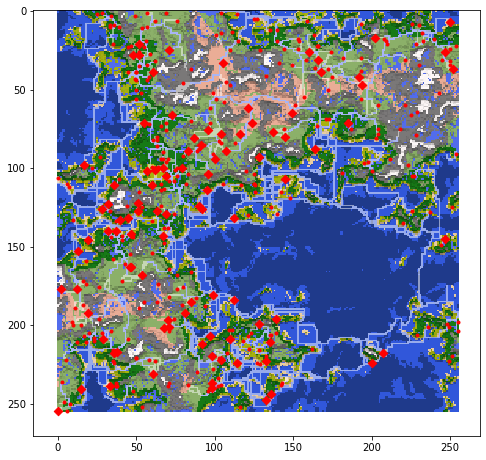

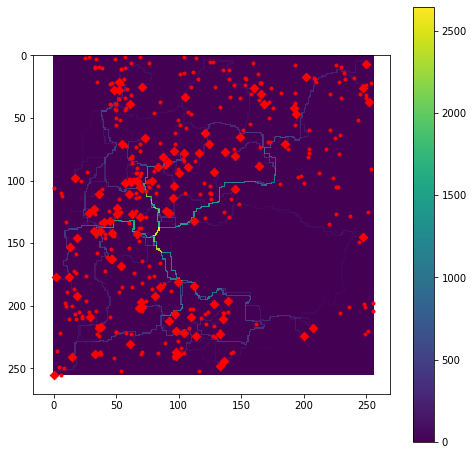

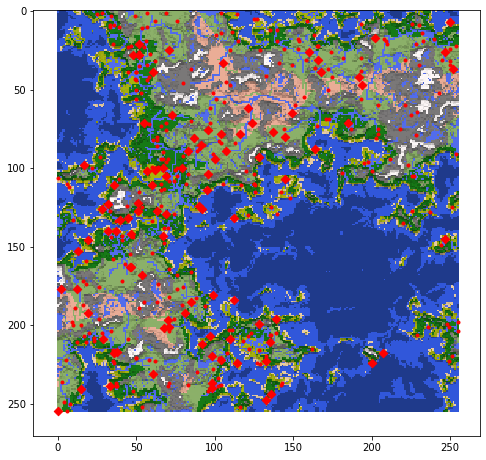

In [2454]:
road=np.zeros((size,size))
def walkRoad(i,j,idst,jdst,orig,weight=1):
    while i!=idst and j!=jdst:
        road[i,j]+=weight
        o=orig[i,j]
        if o==-1:
            break
        i+=dirs[o][0]
        j+=dirs[o][1]
    road[idst,jdst]+=weight
for _i in tqdm(range(len(towns))):
    i,j=int(towns[_i][0]),int(towns[_i][1])
    source=elevation<-1
    source[i,j]=True
    pop_dist,orig=pfa(source=source,
                        cost=travel_cost,
                        banned=elevation<-1,
                        cutoff=5)
    for _j in range(len(towns)):
        if _j==_i:
            continue
        i1,j1=int(towns[_j][0]),int(towns[_j][1])
        #weight=np.sqrt(towns[_i,2]*towns[_j,2])
        if pop_dist[i1,j1]<5:
            walkRoad(i1,j1,i,j,orig,weight=1)
    for _j in range(len(villages)):
        i1,j1=int(villages[_j][0]),int(villages[_j][1])
        if pop_dist[i1,j1]<1.5:
            walkRoad(i1,j1,i,j,orig,weight=1)
    '''plt.figure(figsize=(3,3))
    plt.imshow(np.clip(pop_dist,0,1),cmap='Accent')
    #plt.colorbar()
    plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
    plt.contour(elevation,[0],colors='black')
    plt.contour(elevation,[0.5],colors='grey')
    plt.scatter(villages[tid,1],villages[tid,0],color='red')
    plt.show()'''
def blend_mono(color_world,color,mask):
    a=np.tensordot(mask,[1,1,1],0)
    b=np.tensordot(np.ones(mask.shape),color,0)
    return color_world*(1-a)+b*a
plt.figure(figsize=(8,8))
plt.imshow(blend_mono(color_world,[1,1,1],np.where(road>0,0.5,0)))
plt.scatter(villages[:,1],villages[:,0],c='red',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='red',marker='D')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(road,cmap='viridis')
plt.colorbar()
plt.scatter(villages[:,1],villages[:,0],c='red',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='red',marker='D')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(color_world)
plt.scatter(villages[:,1],villages[:,0],c='red',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='red',marker='D')
plt.show()


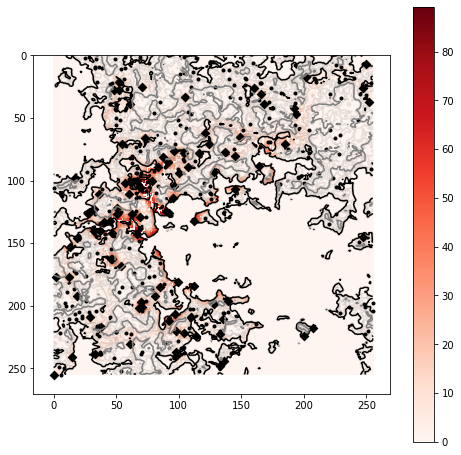

In [2455]:
def get_diffuse_kernel(n,normalized=True):
    x,y=np.mgrid[0:n,0:n]
    x,y=x/(n-1)*2-1,y/(n-1)*2-1
    rtval=np.exp(-(x**2+y**2))
    if normalized:
        rtval/=np.sum(rtval)
    return rtval
population=np.zeros((size,size))
for v in villages:
    population[v[0],v[1]]+=1
for t in towns:
    population[int(t[0]),int(t[1])]+=t[2]

military=convolve2d(road,get_diffuse_kernel(np.int(2*zoom*0.4),False),mode='same')
military=military/np.max(military)*np.max(population)
military+=0.5*convolve2d(population,get_diffuse_kernel(np.int(2*zoom*0.4),False),mode='same')
#military*=(0.5+sigmoid(uneven-2))
military[habitable<=0]=0
plt.figure(figsize=(8,8))
plt.imshow(military,cmap='Reds')
plt.colorbar()
plt.contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
plt.contour(elevation,[0],colors='black')
plt.contour(elevation,[0.5],colors='grey')
plt.scatter(villages[:,1],villages[:,0],c='black',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='black',marker='D')
plt.show()


100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


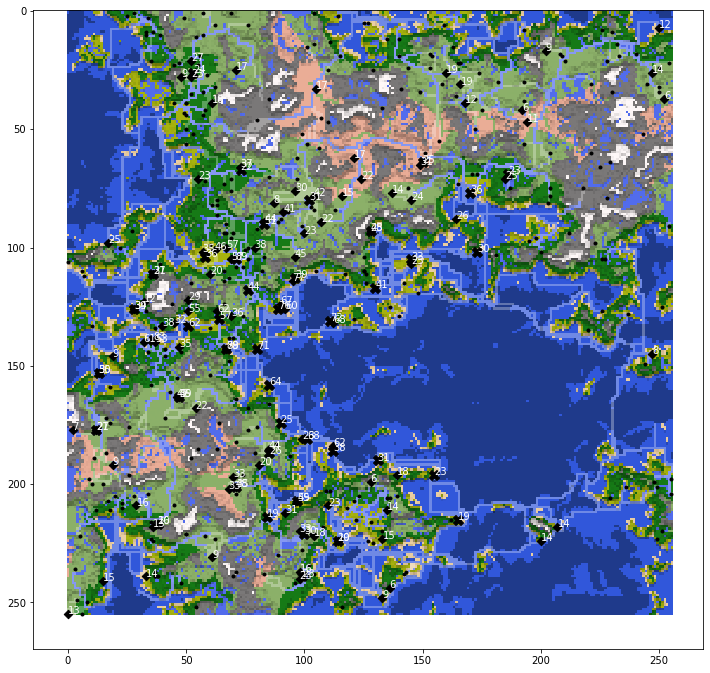

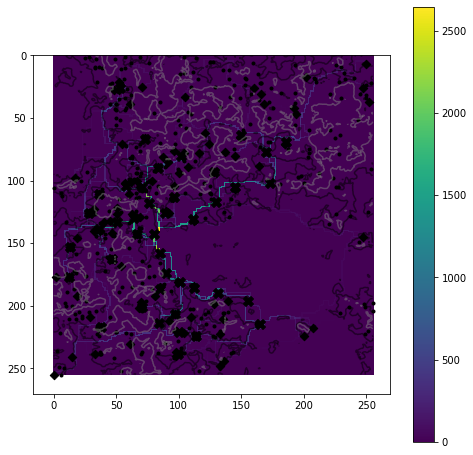

In [2456]:
castles=[]
military_tmp=military.copy()
#military_p=military.flatten()/np.sum(military)
#np.random.seed(seed+1)
for _i in tqdm(range(int(len(villages)/7))):
    #i,j=getij(np.random.choice(size*size,p=military_p))
    i,j=getij(np.argmax(military_tmp))
    castles.append((i,j,military_tmp[i,j]))
    tmp=np.zeros((size,size))
    tmp[i,j]=1
    tmpkernel=get_diffuse_kernel(np.int(2*zoom*.8))
    tmp=1-convolve2d(tmp,tmpkernel/np.max(tmpkernel),mode='same')
    #plt.imshow(military_tmp,cmap='Reds')
    #plt.show()
    military_tmp*=tmp
castles=np.array(castles)
plt.figure(figsize=(12,12))
plt.imshow(blend_mono(color_world,[1,1,1],np.where(road>0,0.3,0)))
plt.scatter(villages[:,1],villages[:,0],c='black',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='black',marker='D')
plt.scatter(castles[:,1],castles[:,0],c='black',marker='X',s=100)
for i in range(len(towns)):
    plt.annotate("{:.0f}".format(towns[i,2]), (towns[i,1], towns[i,0]),color='white')
for i in range(len(castles)):
    plt.annotate("{:.0f}".format(castles[i,2]), (castles[i,1], castles[i,0]),color='white')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(road,cmap='viridis')
plt.colorbar()
plt.contour(elevation,[0],colors='black',alpha=0.5)
plt.contour(elevation,[0.5],colors='grey',alpha=0.5)
plt.scatter(villages[:,1],villages[:,0],c='black',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='black',marker='D')
plt.scatter(castles[:,1],castles[:,0],c='black',marker='X',s=100)
plt.show()

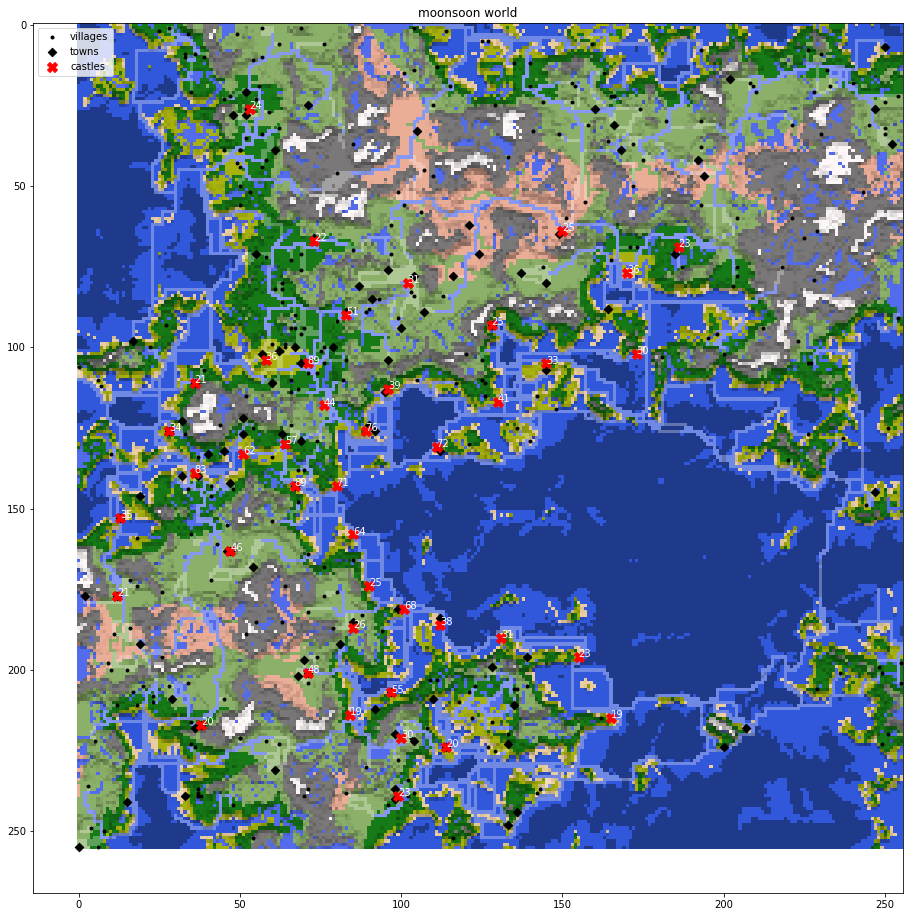

In [2460]:
plt.figure(figsize=(16,16))
plt.imshow(blend_mono(color_world,[1,1,1],np.where(road>0,0.3,0)))
plt.scatter(villages[:,1],villages[:,0],c='black',marker='.')
plt.scatter(towns[:,1],towns[:,0],c='black',marker='D')
plt.scatter(castles[:,1],castles[:,0],c='red',marker='X',s=100)
#for i in range(len(towns)):
    #plt.annotate("{:.0f}".format(towns[i,2]), (towns[i,1], towns[i,0]),color='white')
for i in range(len(castles)):
    plt.annotate("{:.0f}".format(castles[i,2]), (castles[i,1], castles[i,0]),color='white')
plt.legend(['villages','towns','castles'])
plt.title('moonsoon world')
plt.show()

In [2201]:
zoom

16

In [1840]:
assert False


AssertionError: 

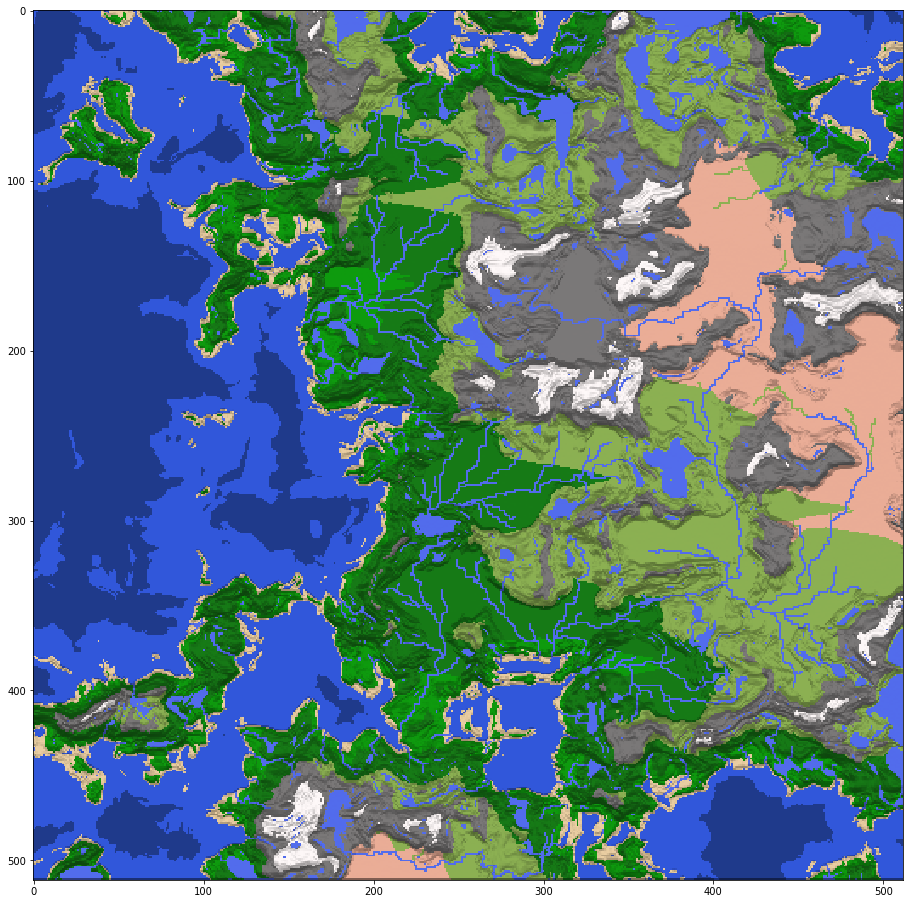

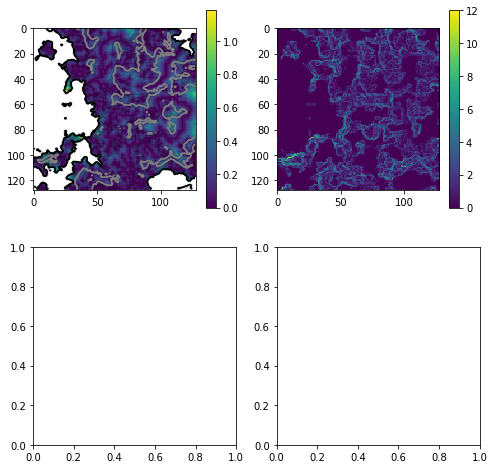

In [1548]:
water_dist,dummy=pfa(source=np.isin(biomes,[biomeID['river'],biomeID['lake']]),
                        cost=np.ones((size,size,4))/zoom,
                        banned=elevation<=0)
uneven=np.abs(gradX)+np.abs(gradY)
ax=plt.figure(figsize=(8,8)).subplots(2,2)
plt.colorbar(ax[0,0].imshow(water_dist,cmap='viridis'),ax=ax[0,0])
ax[0,0].contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
ax[0,0].contour(elevation,[0],colors='black')
ax[0,0].contour(elevation,[0.5],colors='grey')
plt.colorbar(ax[0,1].imshow(uneven,cmap='viridis'),ax=ax[0,1])
ax[0,0].contour(np.clip(elevation,0,1),colors='black',alpha=0.1)
ax[0,0].contour(elevation,[0],colors='black')
ax[0,0].contour(elevation,[0.5],colors='grey')
plt.show()

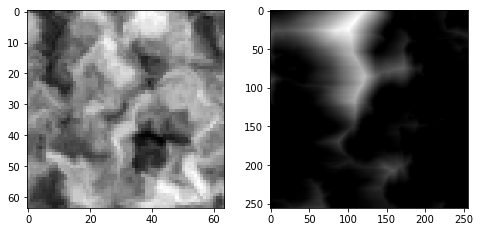

In [396]:
seed=128
elevation = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        x,y=i/16,j/16
        dx=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+15)
        dy=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+23)
        elevation[i][j] = 2*noise.pnoise2(x+0.5*dx,y+0.5*dy,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+0)

plt.figure(figsize=(8,8))
plt.gray()
plt.subplot(221).imshow(elevation)
plt.subplot(222).imshow(dist)
plt.show()

In [488]:
# get river
river=np.zeros((size,size))
dirs=((0,1),(0,-1),(1,0),(-1,0))
np.random.seed(seed+237)
for _i in range(int((size/zoom)**2)*10):
    i,j=np.random.randint(0,size,2)
    p=np.exp(-3*rainshadow[i,j])
    if np.random.random()>=p:
        continue
    amount=30
    while amount>0 and elevation[i,j]>0:
        minneigh=1
        for oo,delta in enumerate(dirs):
            ii,jj=i+delta[0],j+delta[1]
            if 0<=ii and ii<size and 0<=jj and jj<size:
                minneigh=min(minneigh,elevation[ii][jj])
        river[i,j]=np.clip(minneigh-elevation[i][j],0.1,1)
        amount-=1
        ps=np.zeros(4)
        for oo,delta in enumerate(dirs):
            ii,jj=i+delta[0],j+delta[1]
            if 0<=ii and ii<size and 0<=jj and jj<size:
                ps[oo]=np.clip(elevation[i][j]+river[i][j]-elevation[ii][jj],0,1)
        n=np.sum(ps)
        if n==0:
            break
        ps/=n
        o=np.random.choice(4,p=ps)
        i+=dirs[o][0]
        j+=dirs[o][1]
del dirs

In [306]:
#http://w3.marietta.edu/~biol/biomes/biome_main.htm
darkblue = [45,75,155]
blue = [65,105,225]
rainforest=[34,139,34]
grassland=[153,180,112]
forest=[54,189,54]
desert=[238,214,175]
beach=[238, 214, 175]
snow = [255, 250, 250]
mountain = [139, 137, 137]
def get_biome(elevation,temperature,moisture):
    if elevation<-0.4:
        return darkblue
    elif elevation<0:
        return blue
    elif elevation<0.1:
        return beach
    else:
        if temperature>0.75:
            if moisture>0.4:
                return rainforest
            elif moisture>0.2:
                return grassland
            else:
                return desert
        elif temperature>0.5:
            if moisture>0.5:
                return forest
            elif moisture>0.2:
                return grassland
            else:
                return desert
    return [0,0,0] #unknown
    

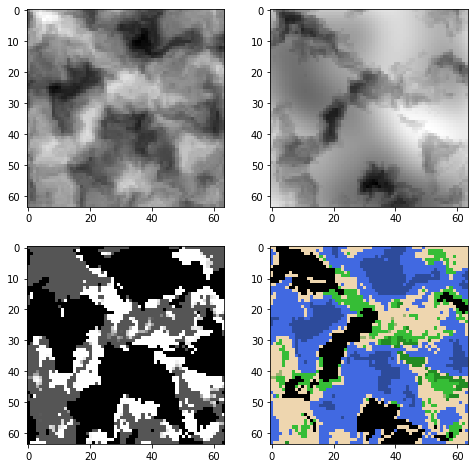

In [223]:
#https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401
#https://minecraft.gamepedia.com/Biome
#http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/
seed=12
elevation = np.zeros((64,64))
temperature = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        x,y=i/16,j/16
        dx=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+15)
        dy=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+23)
        elevation[i][j] = 2*noise.pnoise2(x+0.5*dx,y+0.5*dy,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+0)
        temperature[i][j]=np.clip(0.8-0.5*np.clip(elevation[i][j],0,1)+noise.pnoise2(x/3,y/3,octaves=2,persistence=0.5,lacunarity=2.0,base=seed+18),0,1)
moisture=np.zeros((64,64))
color = np.zeros((64,64,3))
for i in range(64):
    for j in range(64):
        x,y=i/16,j/16
        wx=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+32)
        wy=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+33)
        e0=elevation[i][j]
        e1=sample2D(elevation,i-8*wx,j-8*wy)
        e2=sample2D(elevation,i-16*wx,j-16*wy)
        e3=sample2D(elevation,i-24*wx,j-24*wy)
        e4=sample2D(elevation,i-32*wx,j-32*wy)
        moisture[i][j]+=1 if e1<0 else 0
        moisture[i][j]+=np.clip(1+e0-2*e1,0,1) if e2<0 else 0
        moisture[i][j]+=np.clip(1+e0-e1-e2,0,1) if e3<0 else 0
        moisture[i][j]+=np.clip(1+e0-e2-e3,0,1) if e4<0 else 0
        moisture[i][j]=np.clip(moisture[i][j],0,1)
        moisture[i][j]=-0.5 if e0<0 else moisture[i][j]
        color[i][j]=get_biome(elevation[i][j],temperature[i][j],moisture[i][j])
plt.figure(figsize=(8,8))
plt.gray()
plt.subplot(221).imshow(elevation)
plt.subplot(222).imshow(temperature)
plt.subplot(223).imshow(moisture)
plt.subplot(224).imshow(color/255)
plt.show()

In [224]:

def get_diffuse_kernel(n):
    x,y=np.mgrid[0:n,0:n]
    x,y=x/(n-1)*2-1,y/(n-1)*2-1
    rtval=np.exp(-(x**2+y**2))
    return rtval/np.sum(rtval)
v00=convolve2d(v00,get_diffuse_kernel(6),boundary='wrap')
v01=convolve2d(v01,get_diffuse_kernel(6),boundary='wrap')

In [125]:
np.floor(0.1)

0.0

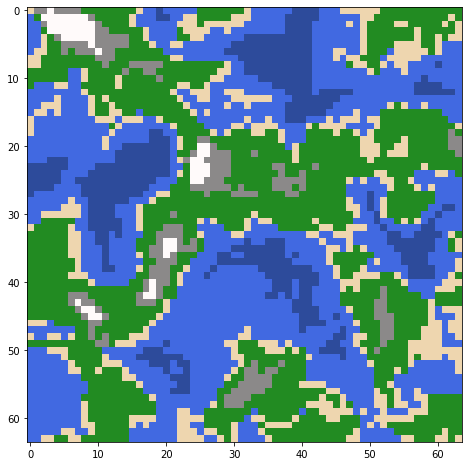

In [179]:
darkblue = [45,75,155]
blue = [65,105,225]
green = [34,139,34]
beach = [238, 214, 175]
snow = [255, 250, 250]
mountain = [139, 137, 137]

def add_color(elevation):
    color_world = np.zeros(elevation.shape+(3,))
    for i in range(elevation.shape[0]):
        for j in range(elevation.shape[1]):
            if elevation[i][j] < -0.4:
                color_world[i][j] = darkblue
            elif elevation[i][j] < 0:
                color_world[i][j] = blue
            elif elevation[i][j] < 0.1:
                color_world[i][j] = beach
            elif elevation[i][j] < 0.5:
                color_world[i][j] = green
            elif elevation[i][j] < 0.7:
                color_world[i][j] = mountain
            else:
                color_world[i][j] = snow
    return color_world/255


color_world = add_color(elevation)
plt.figure(figsize=(8,8))
plt.imshow(color_world)
plt.show()

(-0.4213637411594391, 0.40544167160987854)

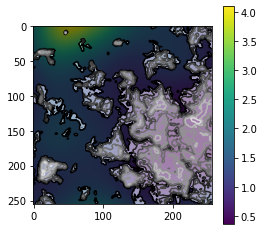

In [798]:
# get elevation
seed=28
size=256
zoom=32
zoom2=8
y0,x0=1,0
distortion=2
elevation = np.zeros((size,size))
gammas = np.zeros((size,size))
xcoord,ycoord=np.mgrid[0:size,0:size]/zoom
for i in range(size):
    for j in range(size):
        x,y=i/zoom+x0,j/zoom+y0
        dx=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+15)
        dy=2*noise.pnoise2(x,y,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+23)
        gamma=noise.pnoise2(x/zoom2,y/zoom2,octaves=2,persistence=0.5,lacunarity=2,base=seed+66)
        gamma=np.exp(3*gamma+0.2)
        value=0.5+noise.pnoise2(x+0.5*dx,y+0.5*dy,octaves=4,persistence=0.5,lacunarity=2.0,base=seed+0)
        value=value**gamma
        gammas[i][j]=gamma
        elevation[i][j] = 2*value-1
#r=np.sqrt((xcoord-2)**2+(ycoord-2)**2)
#elevation=0.5-0.4*((r-0.5)/0.5)**2

plt.figure(figsize=(4,4))
#plt.imshow(np.clip(elevation,0,1))
plt.imshow(gammas,cmap='viridis')
plt.colorbar()
plt.imshow(elevation>0,alpha=0.5)
plt.contour(np.clip(elevation,0,1))
plt.show()